<a href="https://colab.research.google.com/github/AlexTsev/DeepLearning/blob/master/Emotion_Recognition_jaffe_rafd_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random as rnd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob # to read files
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from tensorflow.keras import utils
#import keras
#from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics
import tensorflow.keras.callbacks  as callbacks
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [2]:
from google.colab.patches import cv2_imshow
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
#2.Read Images from the data path
data_path = '/gdrive/My Drive/datasets/jaffe_rafd_dataset/'
data_dir_list = os.listdir(data_path)
filenames = []
#filenames += glob.glob(dirImage+"/*"+".tiff")
filenames += glob.glob(data_path+"/*"+"/*")
print("Processing " + str(len(filenames)) + " image folders")
print(filenames)

In [0]:
img_rows=256
img_cols=256
num_channel=1
img_data_list=[]

# **Load the Viola Jones Classifier**

In [0]:
face_cascade = cv.CascadeClassifier('/gdrive/My Drive/joblib_features/opencv/haarcascade_frontalface_alt.xml')

original image:


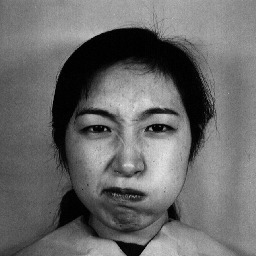

(150, 150, 3)
cropped image:


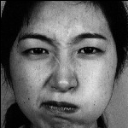

In [5]:
img_path='/gdrive/My Drive/datasets/jaffe_rafd_dataset/ANGRY/angry1.jpg'
img_test = cv.imread(img_path)
print('original image:')
cv2_imshow(img_test)
mask_cv_cascade = face_cascade.detectMultiScale(img_test)
for (x, y, z, h) in mask_cv_cascade:
  crop_imgtest = cv.rectangle(img_test, (x, y), (x + z, y + h), (0, 0, 0), 1)
  crop_imgtest = crop_imgtest[y:y+h, x:x+z]
print(crop_imgtest.shape)
crop_imgtest = cv.resize(crop_imgtest, (128, 128))
print('cropped image:')
cv2_imshow(crop_imgtest)

# **Load The Dataset-Convert to GrayScale-Appply Viola Jones-Resize-Normalize**

In [0]:
i=0
for dataset in data_dir_list:
    img_list = os.listdir(data_path+'/'+ dataset)
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    print(img_list)
    for img in img_list:
        input_img = cv.imread(data_path + '/' + dataset + '/'+ img )
        input_img= cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
        mask_cv_cascade = face_cascade.detectMultiScale(input_img)
        #columnn = face_cascade.detectMultiScale(input_img)
        #print(input_img.shape)
        for (column, row, width, height) in mask_cv_cascade:
          crop_img = cv.rectangle(input_img, (column, row), (column + width, row + height), (0, 255, 0), 1)
          crop_img = crop_img[row:row+height, column:column+width]
        #print(crop_img.shape)
        crop_img = cv.resize(crop_img, (128, 128))
        #cv2_imshow(crop_img)
        img_data_list.append(crop_img)
        i=i+1
print('i:',i)
img_data = np.array(img_data_list)



Loaded the images of dataset-ANGRY

['angry14.jpg', 'angry9.jpg', 'angry24.jpg', 'angry20.jpg', 'angry13.jpg', 'angry17.jpg', 'angry16.jpg', 'angry22.jpg', 'angry8.jpg', 'angry30.jpg', 'angry12.jpg', 'angry18.jpg', 'angry21.jpg', 'angry10.jpg', 'angry28.jpg', 'angry19.jpg', 'angry27.jpg', 'angry29.jpg', 'angry4.jpg', 'angry15.jpg', 'angry23.jpg', 'angry6.jpg', 'angry25.jpg', 'angry1.jpg', 'angry11.jpg', 'angry2.jpg', 'angry5.jpg', 'angry3.jpg', 'angry7.jpg', 'angry26.jpg', 'Rafd090_01_Caucasian_female_angry_frontal.jpg', 'Rafd090_05_Caucasian_male_angry_frontal.jpg', 'Rafd090_05_Caucasian_male_angry_left.jpg', 'Rafd090_03_Caucasian_male_angry_frontal.jpg', 'Rafd090_01_Caucasian_female_angry_left.jpg', 'Rafd090_02_Caucasian_female_angry_frontal.jpg', 'Rafd090_04_Caucasian_female_angry_left.jpg', 'Rafd090_03_Caucasian_male_angry_right.jpg', 'Rafd090_04_Caucasian_female_angry_frontal.jpg', 'Rafd090_02_Caucasian_female_angry_right.jpg', 'Rafd090_02_Caucasian_female_angry_left.jpg', 'Rafd09

In [0]:
img_data = img_data.astype('float32')
img_data = img_data / 255
#print(img_data.shape)

# **Restructure the Dimensions lost from grayscale**

In [0]:
img_data = np.expand_dims(img_data, axis=3)
print(img_data[0].shape)
img_data = img_data*np.ones((1,1,3))
print(img_data[0].shape)

(128, 128, 1)
(128, 128, 3)


In [0]:
print(img_data.shape)

(1620, 128, 128, 3)


# **DEFINE THE LABELS y**

In [0]:
#3.Define the number of classes
num_classes = 7

num_of_samples = img_data.shape[0]
print("num_of_samples:",num_of_samples)
labels = np.ones((num_of_samples,),dtype=int)

num_of_samples: 1620


In [0]:
labels[0:230]=0   
labels[231:463]=1   
labels[464:695]=2 
labels[696:926]=3  
labels[927:1160]=4 
labels[1161:1393]=5 
labels[1394:]=6   

In [0]:
names = ['ANGRY', 'SAD', 'NEUTRAL', 'DISGUST', 'SURPRISE', 'HAPPY', 'FEAR']

def getLabel(id):
    return names[id]

In [0]:
#rnd.seed( 12 )
#4.Convert the class label to one-hot encoding
Y = utils.to_categorical(labels, num_classes)

# **SAVE DATASET WITH JOBLIB TO SKIP THE LOADING PART**

In [0]:
# Saving joblib files to not load them again with the loop above

x_name = 'x.joblib'
y_name = 'y.joblib'
save_dir = '/gdrive/My Drive/joblib_features/jaffe_rafd_dataset/'

savedX = joblib.dump(img_data, os.path.join(save_dir, x_name))
savedy = joblib.dump(Y, os.path.join(save_dir, y_name))

# **LOAD x,Y**

In [0]:
# Loading saved models
x = joblib.load('/gdrive/My Drive/joblib_features/jaffe_rafd_dataset/x.joblib')
y = joblib.load('/gdrive/My Drive/joblib_features/jaffe_rafd_dataset/y.joblib')
##################

# **SHUFFLE**

In [0]:
#Shuffle the dataset
x,y = shuffle(x,y, random_state=123)

**Input Shape**

In [9]:
print(x.shape)
print(x[0].shape)

(1620, 128, 128, 3)
(128, 128, 3)


# **KFOLD SPLIT METHOD**

In [10]:
# Split the dataset with Kfold
acc_test_perfold = []
loss_test_perfold =  []
kfolds=5

kf = KFold(n_splits=kfolds, shuffle= True, random_state=14)# best rnd: 14(120 h 125), 
initializer = tensorflow.keras.initializers.glorot_uniform(seed=123)
#config = initializer.get_config()
#initializer = tensorflow.keras.initializers.glorot_uniform.from_config(config)
#initializer = tensorflow.keras.initializers.GlorotUniform(minval=0., maxval=1.) 
for train_index, test_index in kf.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #5. CNN Layer Set
    # Defining the model
    model = Sequential()

    # Feature Extraction
    model.add(Conv2D(5, (5,5), activation='relu', input_shape=x[0].shape, padding='same'))#, kernel_initializer=initializer
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(15, (5,5), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(120, (5,5), activation='relu'))#
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(180, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    #Compile Model
    optimizer = 'Adam'
    #optimizer = tensorflow.keras.optimizers.Adam.minimize(cross_)
    #optimizer = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()])

    #6.View Model Configuration
    model.summary()
    model.get_config()
    model.layers[0].get_config()
    model.layers[0].input_shape
    model.layers[0].output_shape
    model.layers[0].get_weights()
    np.shape(model.layers[0].get_weights()[0])
    model.layers[0].trainable



    #7. Train Model
    # Training
    hist = model.fit(x_train, y_train, batch_size=90, epochs=100, verbose=1, validation_data=(x_test, y_test))
          #model.fit_generator(gen,epochs=50,callbacks=ModelCheckpoint("model_{binary_accuracy}.hdf5"))

    # Evaluating the model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Val Loss:', score[0])
    print('Val accuracy:', score[1])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 5)       380       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 15)        1890      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 120)       45120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 120)       0

# **REPORT**

In [11]:
from sklearn.metrics import classification_report
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
report_y_test = np.argmax(y_test, axis=1)
print(classification_report(report_y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.92      0.90      0.91        49
           2       0.86      1.00      0.92        42
           3       1.00      0.94      0.97        49
           4       0.97      0.93      0.95        42
           5       0.93      0.93      0.93        44
           6       0.90      0.88      0.89        51

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.94      0.94      0.94       324



# **Plot**

train_acc: 96.37%
train loss: 9.24%
val_acc: 93.83%
val_loss: 22.35%


number of epochs: 100


<Figure size 432x288 with 0 Axes>

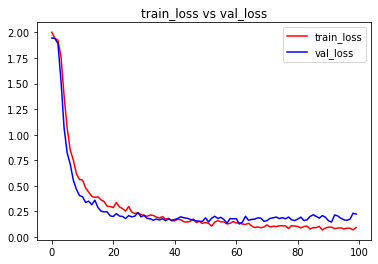

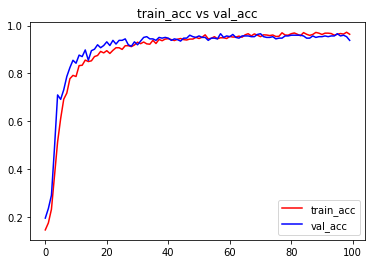

<Figure size 432x288 with 0 Axes>

In [45]:
# Evaluating the model
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])

# visualizing losses and accuracy
#%matplotlib inline
train_acc=hist.history['accuracy']
train_loss=hist.history['loss']
val_acc=hist.history['val_accuracy']
val_loss=hist.history['val_loss']

print("train_acc: "+"{:.2%}".format(train_acc[-1]))
print("train loss: "+"{:.2%}".format(train_loss[-1]))
print("val_acc: "+"{:.2%}".format(val_acc[-1]))
print("val_loss: "+"{:.2%}".format(val_loss[-1]))
print("\n")

print("number of epochs:",len(train_acc))
epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

# **Confusion Matrix Test Set**

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


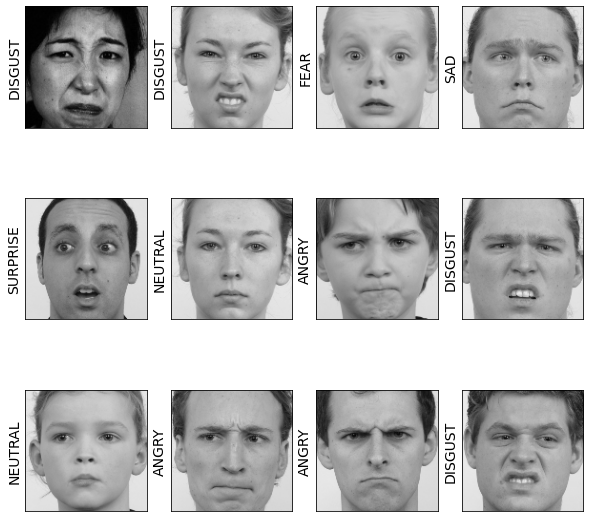

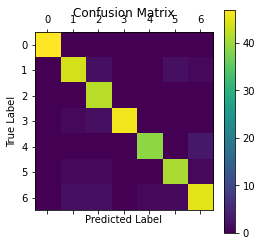

In [13]:
#print(np.where(y_test == 1)[1])
res = model.predict_classes(x_test[0:12])
plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('%s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

#Confusion Matrix Metrics
results = model.predict_classes(x_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Load, Shuffle, Print Input Shape**

In [67]:
# Loading saved models
x = joblib.load('/gdrive/My Drive/joblib_features/jaffe_rafd_dataset/x.joblib')
y = joblib.load('/gdrive/My Drive/joblib_features/jaffe_rafd_dataset/y.joblib')
##################

#Shuffle the dataset
x,y = shuffle(x,y, random_state=123)

print(x.shape)
print(x[0].shape)


(1620, 128, 128, 3)
(128, 128, 3)


# **TRAIN TEST SPLIT METHOD**

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=123)#0.13 , rand=2',3',8'',14, ,123',26',31,36',51'  /34,38',


model2 = Sequential()
#initializer = tensorflow.keras.initializers.glorot_uniform(seed=123)

model2.add(Conv2D(5, (5,5), activation='relu', input_shape=x[0].shape, padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(25, (5,5), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(125, (5,5), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(180, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(7))
model2.add(Activation('softmax'))

#optimizer = Adam(lr=0.0001)
optimizer = 'adam'
#Compile Model
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()])
#model.fit_generator(gen,epochs=50,callbacks=ModelCheckpoint("model_{binary_accuracy}.hdf5"))

#6.View Model Configuration
model2.summary()
model2.get_config()
model2.layers[0].get_config()
model2.layers[0].input_shape
model2.layers[0].output_shape
model2.layers[0].get_weights()
np.shape(model2.layers[0].get_weights()[0])
model2.layers[0].trainable

#from keras import callbacks
filename=(r'/gdrive/My Drive/emotion_recognition/model_train_new2.csv')
filepath=(r"/gdrive/My Drive/emotion_recognition/Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5")
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list2 = [csv_log,checkpoint]
callbacks_list2 = [csv_log]

#7. Train Model
# Training
hist2 = model2.fit(x_train, y_train, batch_size=80, epochs=100, verbose=1, validation_data=(x_test, y_test))#, callbacks=callbacks_list2
#5 batch

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 128, 5)       380       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 64, 64, 5)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 64, 64, 25)        3150      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 25)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 32, 32, 25)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 125)       78250     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 14, 14, 125)     

# **REPORT**

In [71]:
from sklearn.metrics import classification_report
predictions2 = model2.predict(x_test)
predictions2 = np.argmax(predictions2, axis=1)
report_y_test2 = np.argmax(y_test, axis=1)
print(classification_report(report_y_test2, predictions2))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        49
           1       0.98      0.88      0.93        50
           2       0.88      0.94      0.91        48
           3       0.95      0.97      0.96        38
           4       0.86      0.97      0.92        39
           5       0.96      0.96      0.96        45
           6       0.98      0.93      0.95        55

    accuracy                           0.94       324
   macro avg       0.94      0.94      0.94       324
weighted avg       0.94      0.94      0.94       324



# **Model Save**

In [0]:
"""
#Model Save
"""
model.save(r'/gdrive/My Drive/emotion_recognition/model_emotion_recognition_jaffe_rafd.h5')
model.save_weights(r'/gdrive/My Drive/emotion_recognition/model_model_emotion_recognition_jaffe_rafd_weights.h5')

"""
#Model2 Save
"""
model2.save(r'/gdrive/My Drive/emotion_recognition/model_emotion_recognition_jaffe_rafd_2.h5')
model2.save_weights(r'/gdrive/My Drive/emotion_recognition/model_model_emotion_recognition_jaffe_rafd_weights_2.h5')



# **Plot**

train_acc: 96.14%
train loss: 9.55%
val_acc: 93.83%
val_loss: 37.79%


number of epochs: 100


<Figure size 432x288 with 0 Axes>

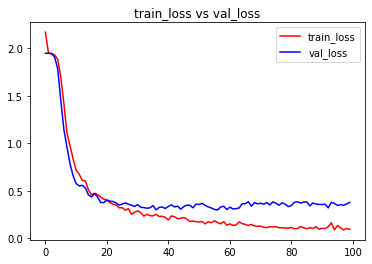

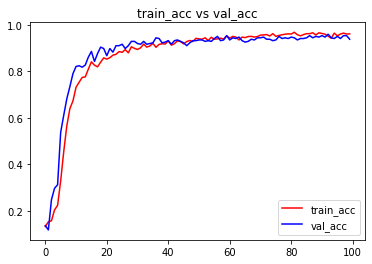

<Figure size 432x288 with 0 Axes>

In [70]:
# Evaluating the model
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])

# visualizing losses and accuracy
#%matplotlib inline
train_acc_2=hist2.history['accuracy']
train_loss_2=hist2.history['loss']
val_acc_2=hist2.history['val_accuracy']
val_loss_2=hist2.history['val_loss']

print("train_acc: "+"{:.2%}".format(train_acc_2[-1]))
print("train loss: "+"{:.2%}".format(train_loss_2[-1]))
print("val_acc: "+"{:.2%}".format(val_acc_2[-1]))
print("val_loss: "+"{:.2%}".format(val_loss_2[-1]))
print("\n")

print("number of epochs:",len(train_acc_2))
epochs = range(len(train_acc_2))

plt.plot(epochs,train_loss_2,'r', label='train_loss')
plt.plot(epochs,val_loss_2,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc_2,'r', label='train_acc')
plt.plot(epochs,val_acc_2,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

# **TEST SET**

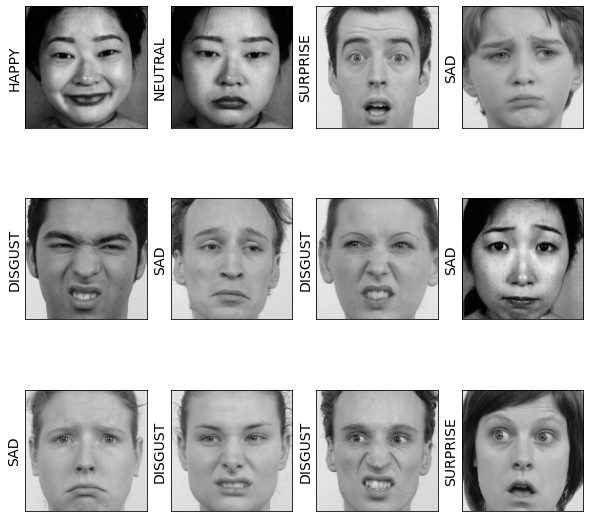

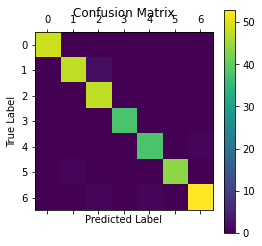

In [69]:
#print(np.where(y_test == 1)[1])
res2 = model2.predict_classes(x_test[0:12])
plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('%s' % getLabel(res2[i]), fontsize=14)
# show the plot
plt.show()

#Confusion Matrix Metrics
results2 = model.predict_classes(x_test)
cm2 = confusion_matrix(np.where(y_test == 1)[1], results2)
plt.matshow(cm2)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **TRAIN SET**

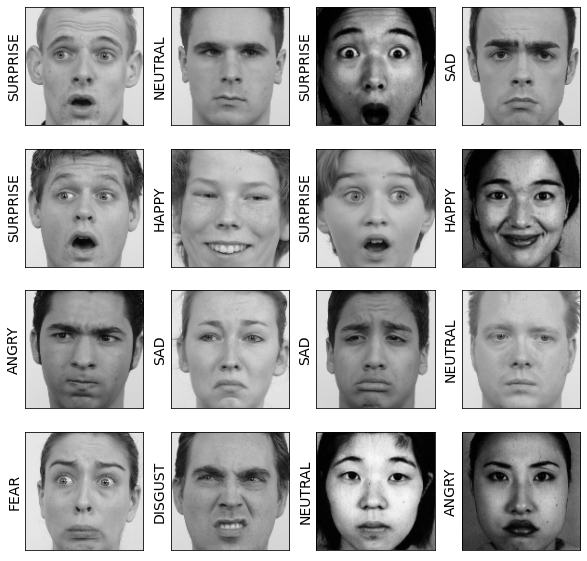

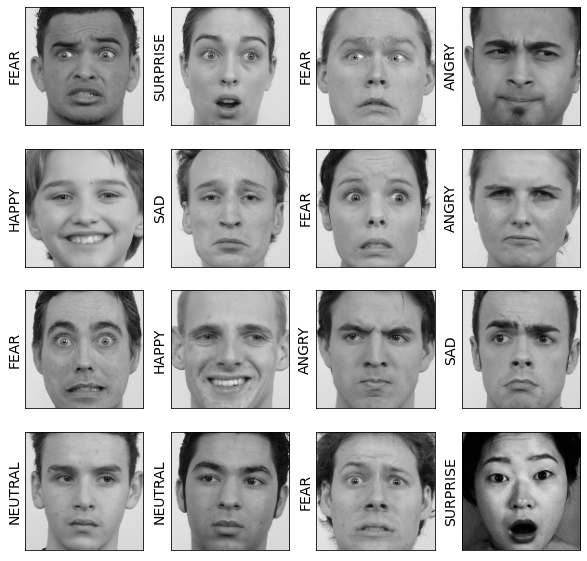

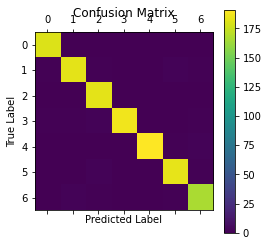

In [72]:
res_train = model.predict_classes(x_train)
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('%s' % getLabel(res_train[i]), fontsize=14)
# show the plot
plt.show()

plt.figure(figsize=(10, 10))
for i in range(16,32):
    plt.subplot(4, 4, i-15)
    plt.imshow(x_train[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('%s' % getLabel(res_train[i]), fontsize=14)
# show the plot
plt.show()

#Confusion Matrix Metrics
#results2 = model.predict_classes(x_train)
cm3 = confusion_matrix(np.where(y_train == 1)[1], res_train)
plt.matshow(cm3)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

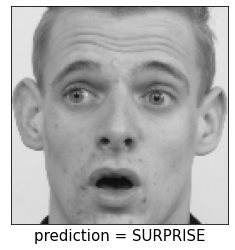

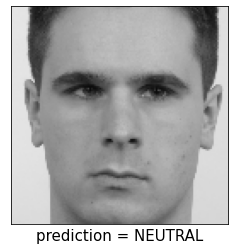

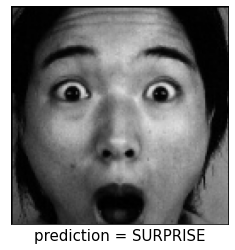

In [74]:
results3 = model.predict_classes(x_train[0:3])
plt.imshow(x_train[0], cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = %s' % getLabel(results3[0]), fontsize=15)
plt.show()

plt.imshow(x_train[1], cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = %s' % getLabel(results3[1]), fontsize=15)
plt.show()


plt.imshow(x_train[2], cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = %s' % getLabel(results3[2]), fontsize=15)
plt.show()


# **Random Set**

test image original shaape (128, 128, 3)
image original shaape (128, 128, 3)


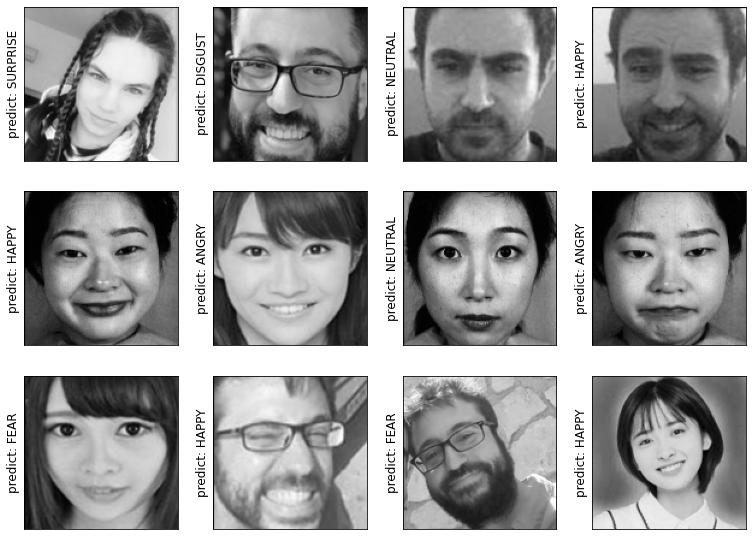

In [76]:
#test other photo

testimg_data_list = []
test_img = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/fifi.jpg')
test_img2 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/aris.jpg')
test_img3 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/me2.jpg')
test_img4 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/me3.jpg')
test_img5 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/happy6.jpg')
test_img6 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/takabeai.jpg')
test_img7 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/neutral3.jpg')
test_img8 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/angry5.jpg')
test_img9 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/jap1.jpg')
test_img10 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/aris2.jpg')
test_img11= cv.imread('/gdrive/My Drive/datasets/my_test_dataset/aris3.jpg')
test_img12 = cv.imread('/gdrive/My Drive/datasets/my_test_dataset/jap2.jpg')

testimg_data_list=[]
testimg_data_list2=[]


cropimg1 = cv.resize(test_img, (128, 128))
testimg_data_list.append(cropimg1)

mask_cv_cascade2 = face_cascade.detectMultiScale(test_img2)
for (x, y, z, h) in mask_cv_cascade2:
  cropimg2 = cv.rectangle(test_img2, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg2 = cropimg2[y:y+h, x:x+z]
  cropimg2 = cv.resize(cropimg2, (128, 128))
  testimg_data_list.append(cropimg2)

mask_cv_cascade3 = face_cascade.detectMultiScale(test_img3)
for (x, y, z, h) in mask_cv_cascade3:
  cropimg3 = cv.rectangle(test_img3, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg3 = cropimg3[y:y+h, x:x+z]
  cropimg3 = cv.resize(cropimg3, (128, 128))
  testimg_data_list.append(cropimg3)

mask_cv_cascade4 = face_cascade.detectMultiScale(test_img4)
for (x, y, z, h) in mask_cv_cascade4:
  cropimg4 = cv.rectangle(test_img4, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg4 = cropimg4[y:y+h, x:x+z]
  cropimg4 = cv.resize(cropimg4, (128, 128))
  testimg_data_list.append(cropimg4)

mask_cv_cascade5 = face_cascade.detectMultiScale(test_img5)
for (x, y, z, h) in mask_cv_cascade5:
  cropimg5 = cv.rectangle(test_img5, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg5 = cropimg5[y:y+h, x:x+z]
  cropimg5 = cv.resize(cropimg5, (128, 128))
  testimg_data_list.append(cropimg5)

mask_cv_cascade6 = face_cascade.detectMultiScale(test_img6)
for (x, y, z, h) in mask_cv_cascade6:
  cropimg6 = cv.rectangle(test_img6, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg6 = cropimg6[y:y+h, x:x+z]
  cropimg6 = cv.resize(cropimg6, (128, 128))
  testimg_data_list.append(cropimg6)

mask_cv_cascade7 = face_cascade.detectMultiScale(test_img7)
for (x, y, z, h) in mask_cv_cascade7:
  cropimg7 = cv.rectangle(test_img7, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg7 = cropimg7[y:y+h, x:x+z]
  cropimg7 = cv.resize(cropimg7, (128, 128))
  testimg_data_list.append(cropimg7)

mask_cv_cascade8 = face_cascade.detectMultiScale(test_img8)
for (x, y, z, h) in mask_cv_cascade8:
  cropimg8 = cv.rectangle(test_img8, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg8 = cropimg8[y:y+h, x:x+z]
  cropimg8 = cv.resize(cropimg8, (128, 128))
  testimg_data_list.append(cropimg8)

mask_cv_cascade9 = face_cascade.detectMultiScale(test_img9)
for (x, y, z, h) in mask_cv_cascade9:
  cropimg9 = cv.rectangle(test_img9, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg9 = cropimg9[y:y+h, x:x+z]
  cropimg9 = cv.resize(cropimg9, (128, 128))
  testimg_data_list.append(cropimg9)

mask_cv_cascade10 = face_cascade.detectMultiScale(test_img10)
for (x, y, z, h) in mask_cv_cascade10:
  cropimg10 = cv.rectangle(test_img10, (x, y), (x + z, y + h), (0, 0, 0), 1)
  cropimg10 = cropimg10[y:y+h, x:x+z]
  cropimg10 = cv.resize(cropimg10, (128, 128))
  testimg_data_list.append(cropimg10)

cropimg11 = cv.resize(test_img11, (128, 128))
testimg_data_list.append(cropimg11)

cropimg12 = cv.resize(test_img12, (128, 128))
testimg_data_list.append(cropimg12)



#print('list',testimg_data_list)
#testimg_data_list = (cropimg1, cropimg2, cropimg3, cropimg4, cropimg5, cropimg6, cropimg7, cropimg8, cropimg9, cropimg10, cropimg11, cropimg12)
testimg_data = np.asarray(testimg_data_list)
#print(testimg_data.shape)
#print(testimg_data[0].shape)
testimg_data = testimg_data.astype('float32')
testimg_data = testimg_data / 255

print("test image original shaape", testimg_data[0].shape)
print("image original shaape", testimg_data[0].shape)

from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep


res4 = model2.predict_classes(testimg_data)
plt.figure(figsize=(13, 13))
for i in range(0,12):
    #clear_output()
    plt.subplot(4, 4, i+1)
    plt.imshow(testimg_data[i], cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('predict: %s' % getLabel(res4[i]), fontsize=12)
# show the plot
plt.show()
sleep(1)


